# TokaMaker mesh builder example for intial NextStep NT study

In [1]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Load TokaMaker library

To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

For meshing we will use the `gs_Domain` class to build a 2D triangular grid suitable for Grad-Shafranov equilibria. This class uses the [triangle code](https://www.cs.cmu.edu/~quake/triangle.html) through a [python wrapper](https://pypi.org/project/triangle/). This example also needs the [h5py](https://www.h5py.org/) python module.

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit.TokaMaker import gs_Domain, save_gs_mesh, create_isoflux

## Set mesh resolution for each region
First we define some target sizes to set the resolution in out grid. These variables will be used later and represent the target edge size within a given region, where units are in meters. In this case we are using a fairly coarse resolution of 16 cm in the plasma region and 60 cm in the vacuum region.

In [3]:
plasma_dx = 0.02
coil_dx = 0.04
vv_dx = 0.03
vac_dx = 0.075

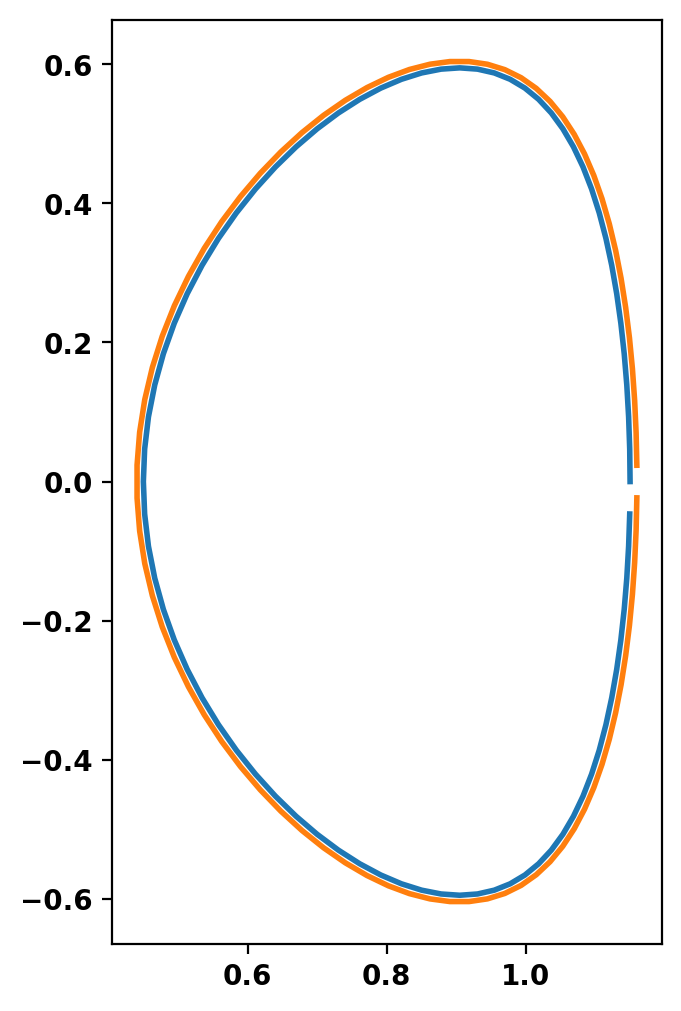

In [4]:
limiter_contour = create_isoflux(80,0.8,0.0,0.35,1.7,-0.3)
# Offset VV outer curve by 1 cm
vv_contour = np.zeros_like(limiter_contour)
for i in range(limiter_contour.shape[0]-1):
    nhat = limiter_contour[i+1,:] - limiter_contour[i,:]; nhat /= np.linalg.norm(nhat)
    vv_contour[i,:] = (limiter_contour[i+1,:] + limiter_contour[i,:])/2.0 + 0.01*np.r_[nhat[1], -nhat[0]]
nhat = limiter_contour[0,:] - limiter_contour[-1,:]; nhat /= np.linalg.norm(nhat)
vv_contour[-1,:] = (limiter_contour[-1,:] + limiter_contour[0,:])/2.0 + 0.01*np.r_[nhat[1], -nhat[0]]
# Plot limiter/VV
fig, ax = plt.subplots(1,1)
ax.plot(limiter_contour[:,0],limiter_contour[:,1])
ax.plot(vv_contour[:,0],vv_contour[:,1])
ax.set_aspect('equal','box')

In [5]:
coils = {
    'CS': {'rc': 0.25, 'zc': 0, 'w': 0.05, 'h': 1.4},
    'EF0U': {'rc': 1.65, 'zc': 0.2, 'w': 0.1, 'h': 0.1},
    'EF1U': {'rc': 1.19, 'zc': 0.7, 'w': 0.1, 'h': 0.1},
    'EF2U': {'rc': 1, 'zc': 0.75, 'w': 0.1, 'h': 0.1},
    'EF3U': {'rc': 1.176*(1.5-1), 'zc': 0.53, 'w': .1, 'h': .1},

    'EF0L': {'rc': 1.65, 'zc': -0.2, 'w': 0.1, 'h': 0.1},
    'EF1L': {'rc': 1.19, 'zc': -0.7, 'w': 0.1, 'h': 0.1},
    'EF2L': {'rc': 1, 'zc': -0.75, 'w': 0.1, 'h': 0.1},
    'EF3L': {'rc': 1.176*(1.5-1), 'zc': -0.53, 'w': .1, 'h': .1},
  
}

## Define regions and attributes
We now create and define the various logical mesh regions. In the current NT design we have 3 regions:
 - `air`: The region outside the vacuum vessel, which is not necissarily air in superconducting devices we use this terminology for commonality with present research devices
 - `plasma`: The region inside the limiter where the plasma will exist
 - `PF1,...`: Each of the 7 coils in the present rough design (1 CS, 6 PF)

For each region you can provide a target size and one of four region types:
 - `plasma`: The region where the plasma can exist and the classic Grad-Shafranov equation with $F*F'$ and $P'$ are allowed. **There can only be one region of this type**
 - `vacuum`: A region where not current can flow and $\nabla^* \psi = 0$ is solved
 - `boundary`: A special case of the `vacuum` region, which forms the outer boundary of the computational domain. **A region of this type is required if more than one region is specified**
 - `conductor`: A region where toroidal current can flow passively (no externally applied voltage). For this type of region the resistivity should be specified with the argument `eta` in units of $\omega \mathrm{-m}$.
 - `coil`: A region where toroidal current can flow with specified amplitude through `set_coil_currents` or via shape optimization `set_coil_reg` and `set_isoflux`

In [6]:
# Create a G-S domain
gs_mesh = gs_Domain()
# Define region information for mesh
gs_mesh.define_region('air',vac_dx,'boundary')
gs_mesh.define_region('plasma',plasma_dx,'plasma')
gs_mesh.define_region('vv',vv_dx,'conductor',eta=1.E-7)
# Define each of the PF coils
for key, coil in coils.items():
    gs_mesh.define_region(key,coil_dx,'coil')

## Define geometry for region boundaries
Once the region types and properties are defined we now define the geometry of the mesh using shapes and references to the defined regions.
 1. We add an example vacuum vessel as an "annulus" with curves defining the inner and outer edges respectively. We also reference `plasma` as the region enclosed by the annulus, `vv` as the annular region itself, and `air` as the region outside the annulus. In this case the inner VV surface forms the limiter.
 2. We add each of the 7 coils as "rectangles", which are defined by a center point (R,Z) along with a width (W) and height (H). We also reference `air` as the region outside the rectangle for all coils.

In [7]:
# Define geometry
gs_mesh.add_annulus(limiter_contour,'plasma',vv_contour,'vv',parent_name='air')
# Define the shape of the PF coils
for key, coil in coils.items():
    gs_mesh.add_rectangle(coil['rc'],coil['zc'],coil['w'],coil['h'],key,parent_name='air')

## Plot topology
After defining the logical and physical topology we can now plot the curves within the definitions to double check everything is in the right place.

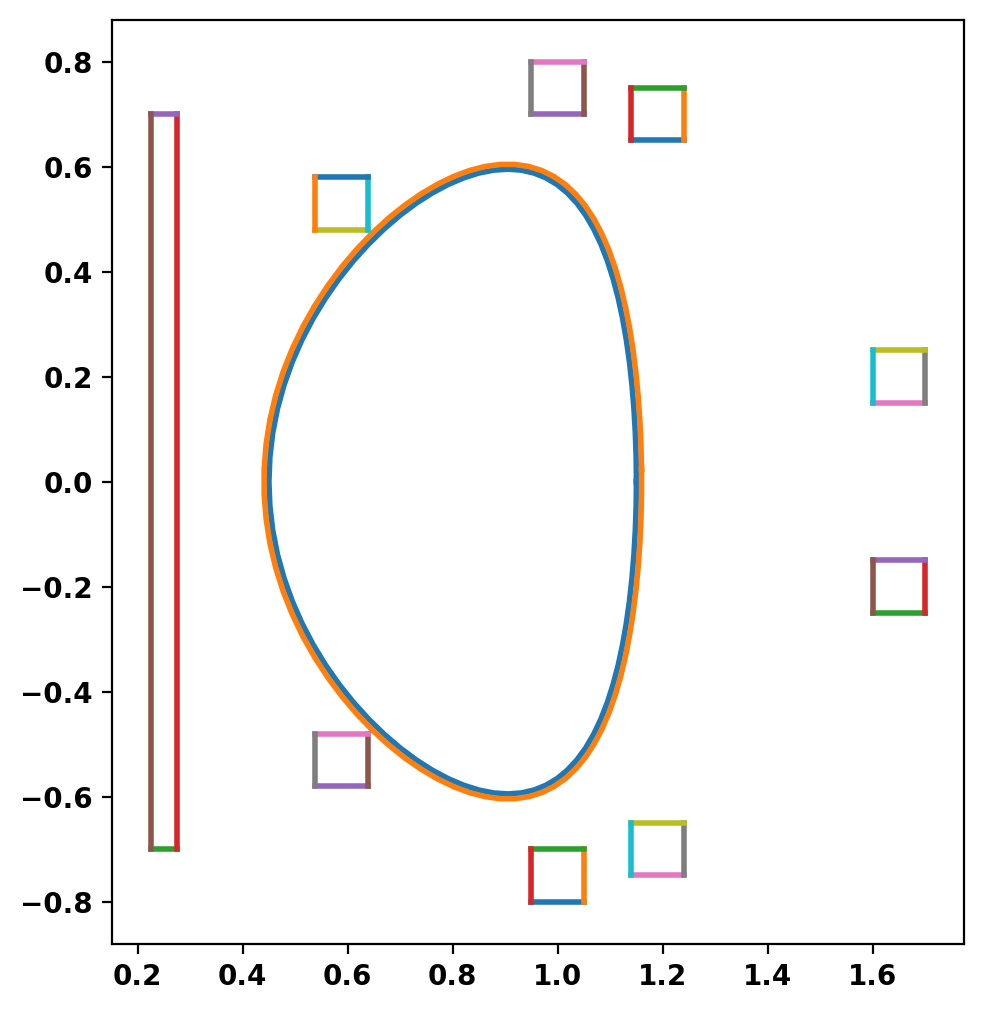

In [8]:
fig, ax = plt.subplots(1,1)
for region in gs_mesh.regions:
    region.plot_segments(fig,ax)
ax.set_aspect('equal','box')

## Create mesh
Now we generate the actual mesh using the `build_mesh` method. Additionally, if `coil` and/or `conductor` regions are defined the `get_coils` and `get_conductors` methods should also be called to get descriptive dictionaries for later use in TokaMaker. This step may take a few moments as [triangle](https://www.cs.cmu.edu/~quake/triangle.html) generates the mesh.

Note that, as is common with unstructured meshes, the mesh is stored a list of points `mesh_pts` of size (np,2), a list of cells formed from three points each `mesh_lc` of size (nc,3), and an array providing a region id number for each cell `mesh_reg` of size (nc,), which is mapped to the names above using the `coil_dict` and `cond_dict` dictionaries.

In [9]:
mesh_pts, mesh_lc, mesh_reg = gs_mesh.build_mesh()
coil_dict = gs_mesh.get_coils()
cond_dict = gs_mesh.get_conductors()

Assembling regions:
  # of unique points    = 493
  # of unique segments  = 42
Generating mesh:
  # of points  = 3710
  # of cells   = 7314
  # of regions = 12


## Plot resulting regions and grid
We now plot the mesh by region to inspect proper generation.

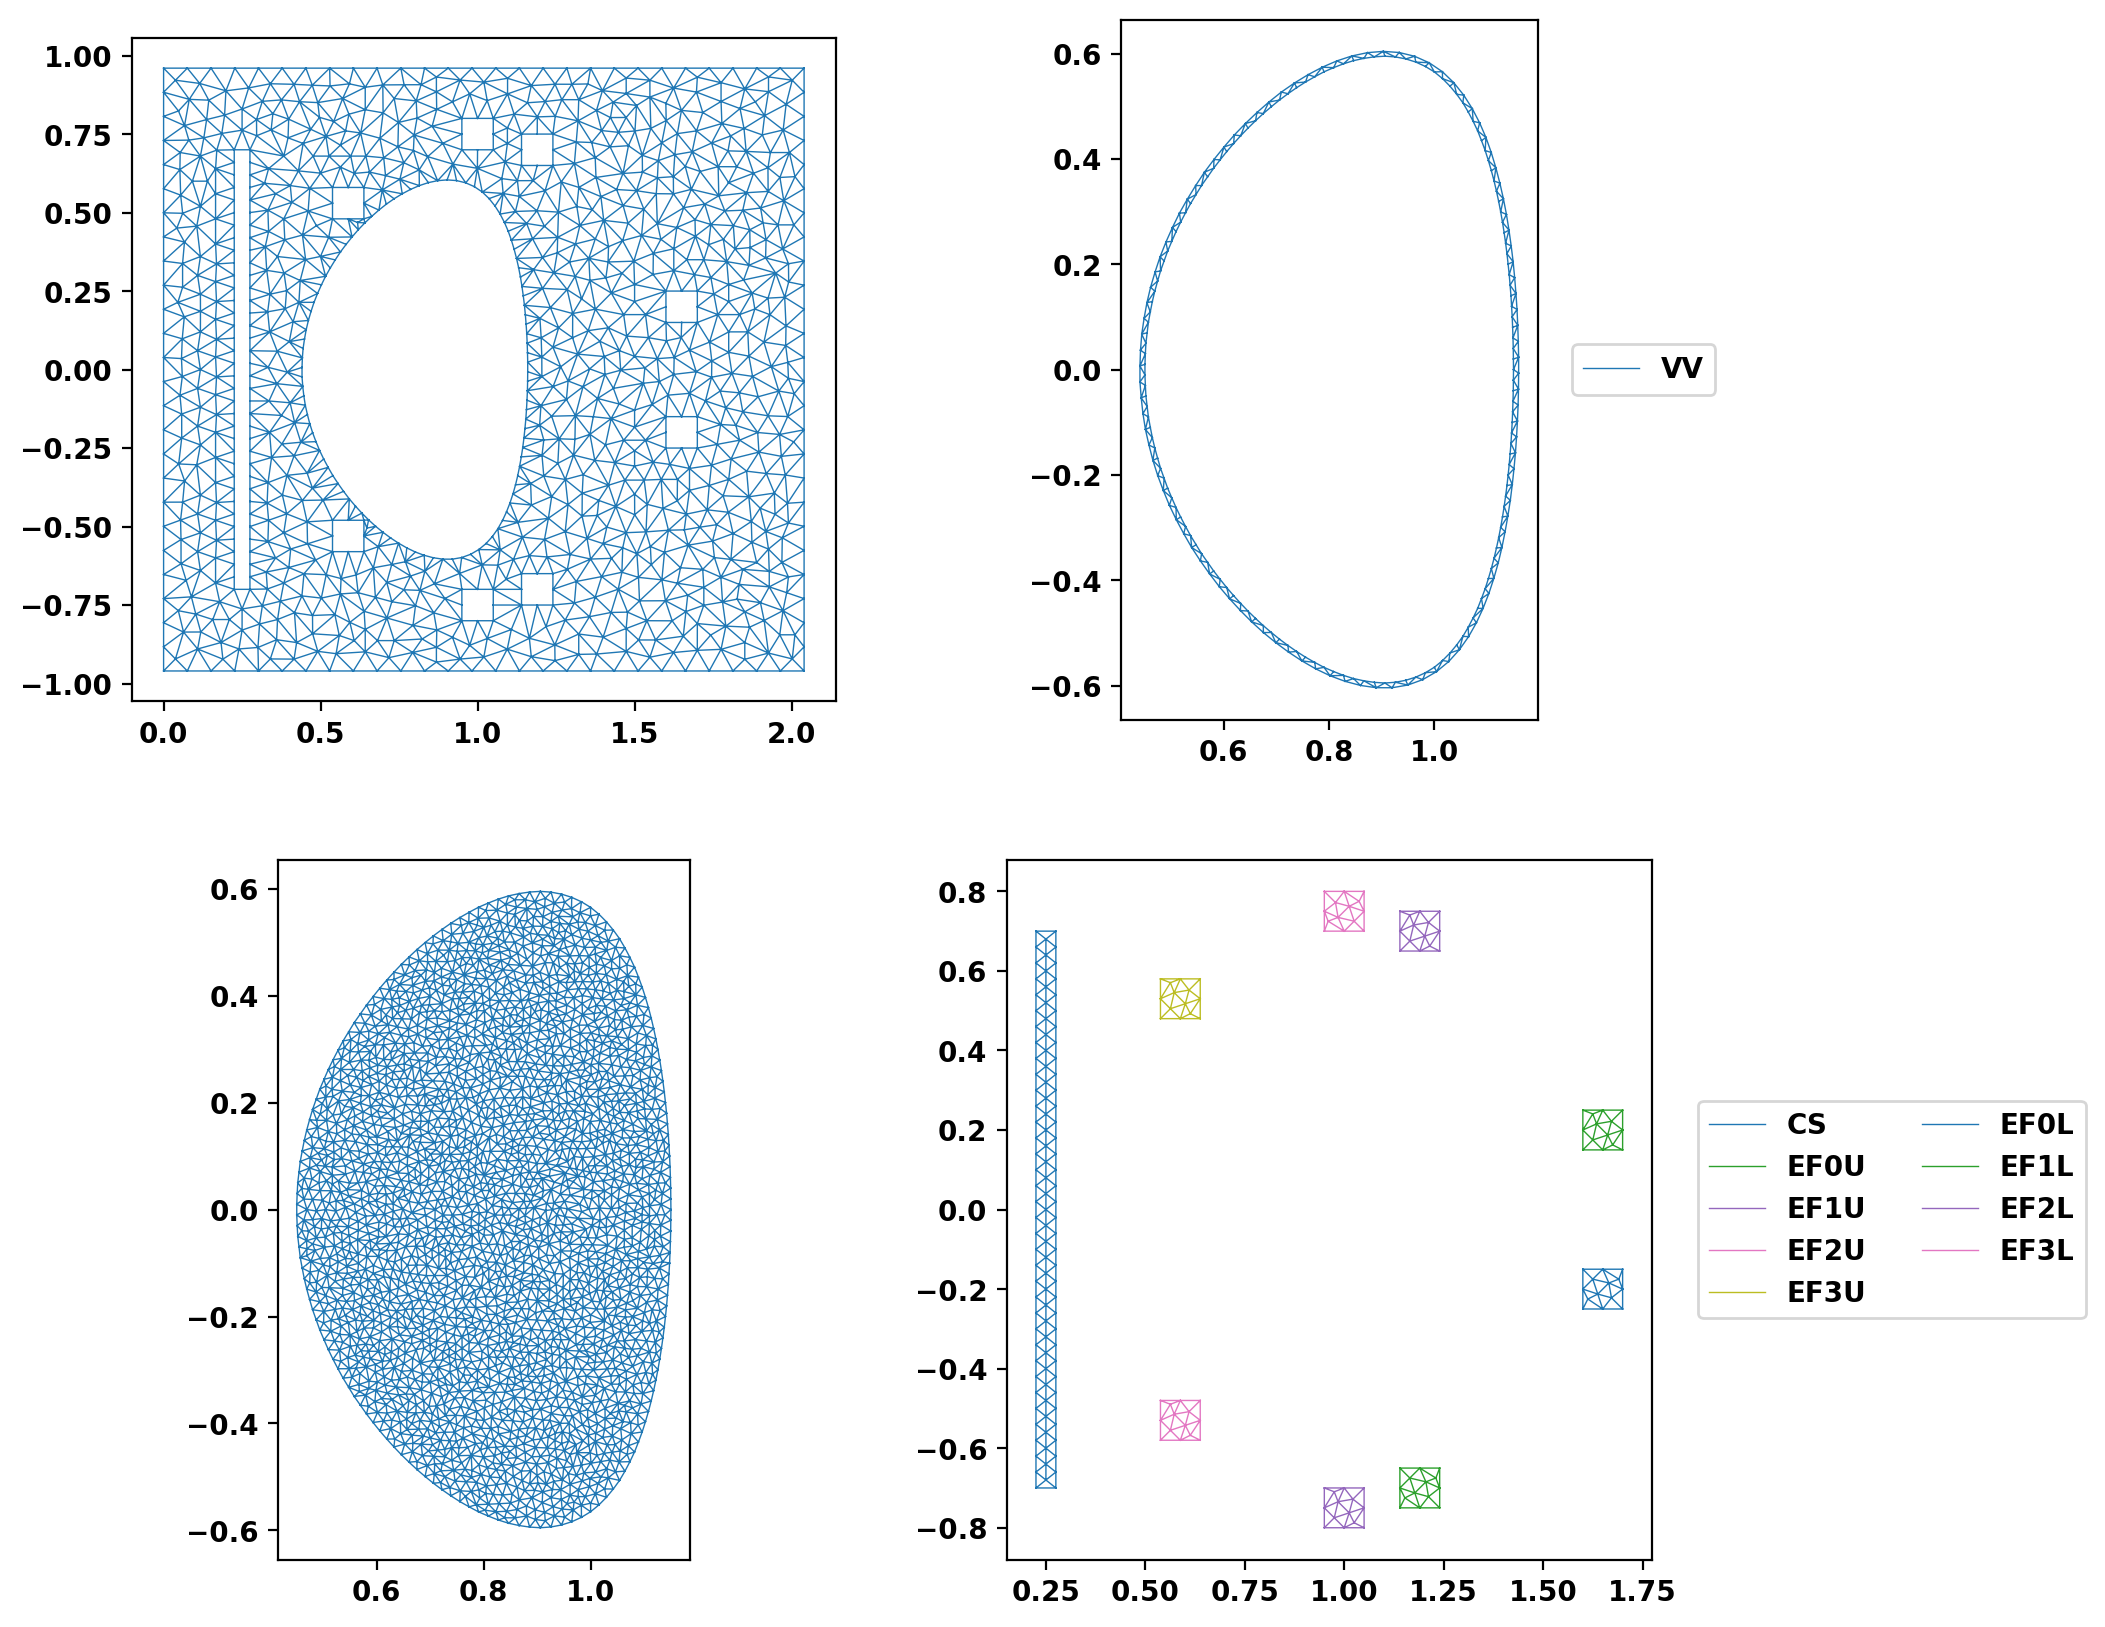

In [10]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].triplot(mesh_pts[:,0],mesh_pts[:,1],mesh_lc[mesh_reg==2,:],lw=0.5)
ax[1,0].triplot(mesh_pts[:,0],mesh_pts[:,1],mesh_lc[mesh_reg==1,:],lw=0.5)
for key, cond in cond_dict.items():
    ax[0,1].triplot(mesh_pts[:,0],mesh_pts[:,1],mesh_lc[mesh_reg==cond['reg_id'],:],lw=0.5,label=key)
for key, coil in coil_dict.items():
    ax[1,1].triplot(mesh_pts[:,0],mesh_pts[:,1],mesh_lc[mesh_reg==coil['reg_id'],:],lw=0.5,label=key)
for ax_tmp in ax.flatten():
    ax_tmp.set_aspect('equal','box')
ax[0,1].legend(bbox_to_anchor=(1.05,0.5), loc='center left')
_ = ax[1,1].legend(bbox_to_anchor=(1.05,0.5), ncol=2, loc='center left')

## Save mesh for later use
As generation of the mesh often takes comparable, or longer, time compare to runs in TokaMaker it is useful to separate generation of the mesh into a different script as demonstrated here. The method `save_gs_mesh` can be used to save the resulting information for later use. This is done using and an [HDF5](https://www.hdfgroup.org/solutions/hdf5/) file through the [h5py](https://www.h5py.org/) library.

In [11]:
save_gs_mesh(mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict,'NextStep_NT_mesh.h5')